# CAP 394-1 - Introdução à Data Science
### Eduardo Pereira de Sousa
## Tema: Decomposição de Software por meio do Acoplamento Semântico

A qualidade de um software pode ser medida por diferentes pontos de vista, dentre esses, a análise de métricas do código-fonte é um dos mais relevantes ao processo de desenvolvimento e manutenção.

Essas métricas expressam diferentes características do código-fonte, no caso de softwares orientados à objeto é comum o uso das métricas propostas por _Chidamber e Kemerer_ (CK), como: número de métodos por classe, acoplamento entre classes e coesão entre métodos de uma classe.

Essas métricas servem de base para diversas ferramentas e métodos de análise, como os _bad smells_, que são características de classes e métodos que podem indicar a ocorrência de problemas mais graves nesses componentes. Uma classe possui um determinado _bad smell_ caso suas métricas ultrapassem um conjunto pré-definido de limiares.

_Aniche et al._ mostrou que esses limiares podem ser mais eficientes na identificação dos _bad smells_ caso se considere o papel do componente na arquitetura do software na definição dos limiares sob os quais cada classe será avaliada.

A definição do papel arquitetural de uma determinada classe frente ao software que ela compõe é por si só uma questão em aberto, visto que o método aplicado por _Aniche et al._ baseia-se em características próprias dos _frameworks_ Spring MVC e Android, as quais não podem ser aplicadas de forma geral a outros softwares, ainda que desenvolvidos na mesma linguagem.

Nesse ponto, o trabalho de _Bavota et al_ evidencia um possível caminho na decomposição de sistemas de software por meio do acoplamento semântico de seus componentes. Seu trabalho aponta que o acoplamento semântico é aquele capaz de expressar com maior fidelidade a percepção dos próprios desenvolvedores, quando comparado a outros métodos de análise do acoplamento. O acoplamento semântico utiliza a similaridade do vocabulário de classes e métodos como forma de evidenciar as relações entre esses componentes.

Neste trabalho, exploraremos diferentes metodologias e técnicas para obtenção, visualização e análise do vocabulário, comparando essas abordagens quanto a capacidade de recuperar a decomposição original da aplicação em pacotes e segundo o método originalmente usado por Aniche et al. na análise de projetos desenvolvidos com o framework Spring MVC. Nosso objetivo é explorar e verificar o comportamento e os resultados obtidos com diferentes abordagens, além de explorar técnicas que permitam a visualização dos dados obtidos.

## Clone GitHub Repository

In [1]:
import os
from git import Repo

In [2]:
# Set the project to be retrieved
project_org = 'spring-projects'
project_name = 'spring-petclinic'
# Where to store the repository locally
local_path = os.path.join('./repositories', project_org, project_name)
# From where to grab the repository
github_url = 'https://github.com/{}/{}.git'.format(project_org, project_name)

In [3]:
# Clone the repository
try:
    Repo.clone_from(github_url, local_path, depth=1)
except:
    print('something wrong is not right...')

something wrong is not right...


## Extract Corpus from Java Source Code

In [4]:
from sklearn.datasets.base import Bunch
import javalang
import glob
import io

In [5]:
tokens_to_grab = [javalang.tokenizer.Identifier, javalang.tokenizer.String]

In [6]:
def extract_corpus(token_list, after_line):
    corpus = []
    line_words = []
    line_number = 0
    for token in token_list:
        token_line = token.position[0]
        if token_line < after_line:
            continue
        if token_line > line_number:
            line_number = token_line
            if len(line_words) > 0:
                corpus.append(' '.join(line_words))
                line_words = []
        if type(token) in tokens_to_grab:
            line_words.append(token.value.strip())
    if len(line_words) > 0:
        corpus.append(' '.join(line_words))
    return '\n'.join(corpus)

def get_source_code(filename):
    f = io.open(filename, 'r', encoding="utf-8")
    source_code = f.read()
    f.close()
    return source_code

def in_project_path(project_path, file_path):
    return file_path[len(project_path):]

def get_project_corpus(project_path):
    data = []
    path = []
    for filename in glob.iglob(project_path + "/**/*.java", recursive=True):
        source_code = get_source_code(filename)
        try:
            ast = javalang.parse.parse(source_code)
            if len(ast.types) == 0:
                break
            start_line = ast.types[0].position[0]
            token_list = list(javalang.tokenizer.tokenize(source_code))
            path.append(in_project_path(project_path, filename))
            data.append(extract_corpus(token_list, start_line))
        except javalang.parser.JavaSyntaxError as e:
            print("Syntax error parsing {}".format(filename))
    
    return Bunch(data=data,
                path=path)

corpus = get_project_corpus(local_path)

## WordCloud

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

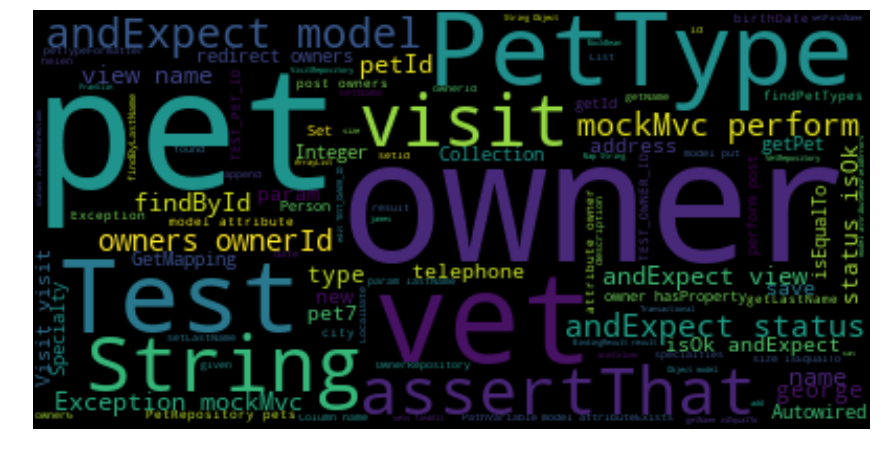

In [8]:
plt.rcParams['figure.figsize'] = [15, 10]
wc = wordcloud = WordCloud().generate(' '.join(corpus.data))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Text Vectorizing

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [10]:
# Create sparse matrix of word counts
count_vectorizer = CountVectorizer(analyzer='word', min_df = 0)
count_matrix = count_vectorizer.fit_transform(corpus.data)
# Transform count to frequency (TF/IDF)
tf_transformer = TfidfTransformer(use_idf=True)
freq_matrix =  tf_transformer.fit_transform(count_matrix)

## Similarities

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = cosine_similarity(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [(index, cosine_similarities[index]) for index in related_docs_indices][0:top_n]

def most_similar(tfidf_matrix, index):
    return find_similar(tfidf_matrix, index, 1)[0]

In [12]:
for index, path in enumerate(corpus.path):
    most_similar_index, score = most_similar(freq_matrix, index)
    print('{} is {:.2f}% similar to {}'.format(path[53:], score*100, corpus.path[most_similar_index][53:]))

PetclinicIntegrationTests.java is 65.02% similar to vet/VetController.java
service/EntityUtils.java is 3.25% similar to service/ClinicServiceTests.java
service/ClinicServiceTests.java is 38.15% similar to owner/OwnerController.java
owner/PetControllerTests.java is 73.15% similar to owner/VisitControllerTests.java
owner/PetTypeFormatterTests.java is 55.07% similar to owner/PetTypeFormatter.java
owner/OwnerControllerTests.java is 68.17% similar to owner/PetControllerTests.java
owner/VisitControllerTests.java is 73.15% similar to owner/PetControllerTests.java
system/CrashControllerTests.java is 56.06% similar to owner/OwnerControllerTests.java
vet/VetTests.java is 36.94% similar to vet/VetRepository.java
vet/VetControllerTests.java is 43.72% similar to system/CrashControllerTests.java
model/ValidatorTests.java is 18.60% similar to service/ClinicServiceTests.java
PetClinicApplication.java is 3.87% similar to owner/Owner.java
owner/OwnerController.java is 49.51% similar to owner/PetControll

## Clustering

In [13]:
from sklearn.cluster import KMeans

In [14]:
number_of_clusters = 2
km = KMeans(n_clusters=number_of_clusters,init='k-means++', max_iter=100, n_init=1)
km.fit(freq_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=2, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [15]:
for i, c in enumerate(km.labels_):
    print(c, corpus.path[i])

1 /src/test/java/org/springframework/samples/petclinic/PetclinicIntegrationTests.java
0 /src/test/java/org/springframework/samples/petclinic/service/EntityUtils.java
1 /src/test/java/org/springframework/samples/petclinic/service/ClinicServiceTests.java
0 /src/test/java/org/springframework/samples/petclinic/owner/PetControllerTests.java
0 /src/test/java/org/springframework/samples/petclinic/owner/PetTypeFormatterTests.java
0 /src/test/java/org/springframework/samples/petclinic/owner/OwnerControllerTests.java
0 /src/test/java/org/springframework/samples/petclinic/owner/VisitControllerTests.java
0 /src/test/java/org/springframework/samples/petclinic/system/CrashControllerTests.java
1 /src/test/java/org/springframework/samples/petclinic/vet/VetTests.java
1 /src/test/java/org/springframework/samples/petclinic/vet/VetControllerTests.java
0 /src/test/java/org/springframework/samples/petclinic/model/ValidatorTests.java
0 /src/main/java/org/springframework/samples/petclinic/PetClinicApplication

In [16]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = count_vectorizer.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :5]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: owner pets andexpect pet pettype
Cluster 1: vets vet visit findall integer
